In [15]:
# Install scipy and numpy
%pip install scipy numpy pandas matplotlib termcolor tabulate

Note: you may need to restart the kernel to use updated packages.


In [16]:
# Import necessary libraries
from scipy import stats
import pandas as pd

In [17]:
class Data:
    def __init__(self, blame_units,blame_spans,critical_units,critical_spans):
            assert len(blame_units)==len(blame_spans)
            assert len(critical_units)==len(critical_spans)
            self.blame = pd.DataFrame(list(zip(blame_units,blame_spans)), columns=["Unit", "Duration"])
            self.critical_chain = pd.DataFrame(list(zip(critical_units,critical_spans)), columns=["Unit", "Duration"])


def split_blame_critical_chain(file: str)-> Data:
    blame_spans = []
    blame_units = []
    critical_units = []
    critical_spans = []
    with open(file) as f:
        for line in f.readlines():
            if line[0]=='=':
                continue
            if len(line) == 0:
                continue
            if line.startswith('The time'):
                continue
            # What we have now is either:
            # blame data formatted as: "timespan systemd-unit"
            # or
            # critical chain data, formatted as: "\s+systemd-unit @timepoint +timespan"
            # being the optional "+timespan" only present on those units systemd flagged as
            # the units that critically slow down the boot.
            entries = line.split()
            countOfFields = len(entries)
            if countOfFields < 2 or countOfFields > 5:
                f"Warning: skipping strange line: {line}"
                continue
            if entries[0]=="-": # A critical chain line ['-', 'snapd.seeded.service', '@2.833s', '+832ms']
                if countOfFields!=4:
                    continue # We only care about the lines with the +timespan line
                delta = pd.Timedelta(entries[3])
                critical_spans.append(delta.total_seconds() * 1000)
                critical_units.append(entries[1])
                # This line is done
                continue
                
            try:
                delta = pd.Timedelta(entries[0])
                blame_spans.append(delta.total_seconds() * 1000)
                blame_units.append(entries[1])
            except ValueError:
                f"Warning: failed to parse line {line}"
                continue

    return Data(blame_units, blame_spans, critical_units, critical_spans)



term = split_blame_critical_chain("../terminate-blame-chain.txt")
shut = split_blame_critical_chain("../shutdown-blame-chain.txt")

term2 = split_blame_critical_chain("./terminate-blame-chain.txt")
shut2 = split_blame_critical_chain("./shutdown-blame-chain.txt")

Of 80 samples collected, the following units appear in the critical chain as units that critically slowed down boot time according to systemd:

In [18]:
term2.critical_chain.groupby('Unit').size()

Unit
snapd.seeded.service              40
snapd.socket                      40
systemd-journal-flush.service     40
systemd-journald.service          40
systemd-timesyncd.service         40
systemd-tmpfiles-setup.service    40
dtype: int64

In [19]:
shut2.critical_chain.groupby('Unit').size()

Unit
snapd.seeded.service              40
snapd.socket                      40
systemd-journal-flush.service     40
systemd-journald.service          40
systemd-timesyncd.service         40
systemd-tmpfiles-setup.service    40
dtype: int64

In [20]:
def filter_outliers(df: pd.DataFrame, column: str) -> pd.DataFrame:
    mean_duration = df[column].mean()
    std_duration = df[column].std()
    threshold = 3 

    upper_bound = mean_duration + threshold * std_duration
    lower_bound = mean_duration - threshold * std_duration

    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

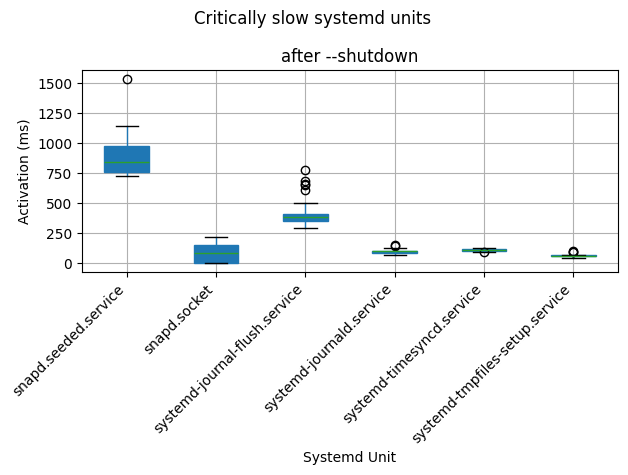

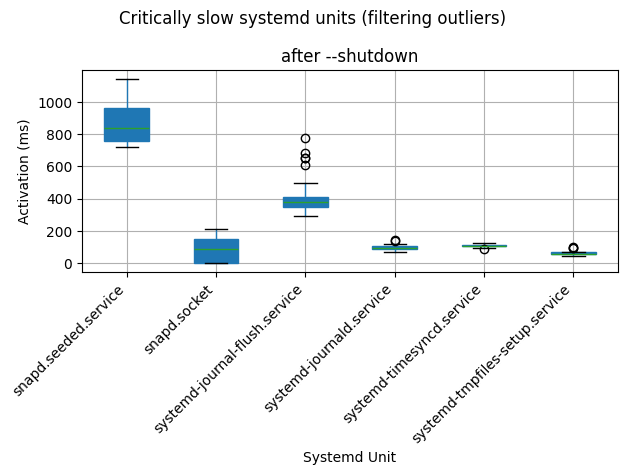

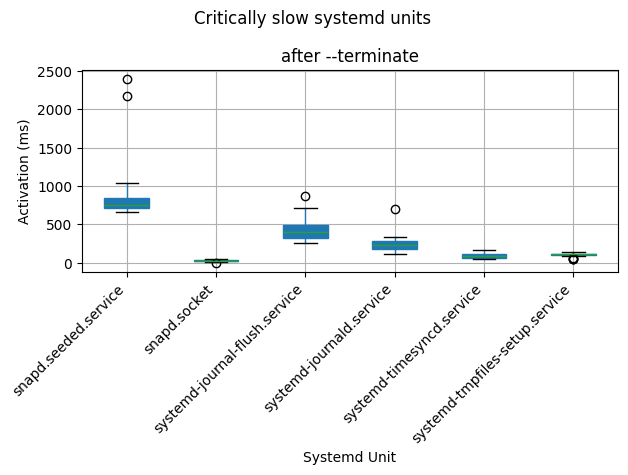

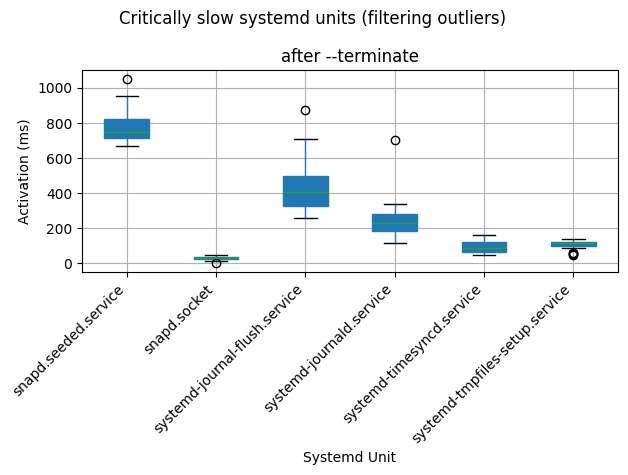

In [21]:
import matplotlib.pyplot as plt


# Function to generate box plots for a specific case
def plot_chain(df: pd.DataFrame, annotation: str, with_outliers=True):
    filtered = df
    title = 'Critically slow systemd units'
    if not with_outliers:
        title += ' (filtering outliers)'
        filtered = filter_outliers(df, 'Duration')

    ax=filtered.boxplot(column='Duration', by='Unit',  patch_artist=True)
    
    plt.suptitle(title)
    plt.title(annotation)
    plt.xlabel('Systemd Unit')
    plt.ylabel('Activation (ms)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


plot_chain(shut2.critical_chain, 'after --shutdown')
plot_chain(shut2.critical_chain, 'after --shutdown', False)

plot_chain(term2.critical_chain,'after --terminate')
plot_chain(term2.critical_chain,'after --terminate', False)


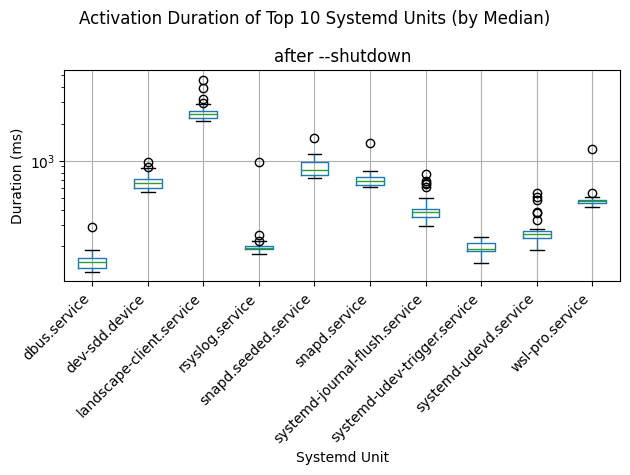

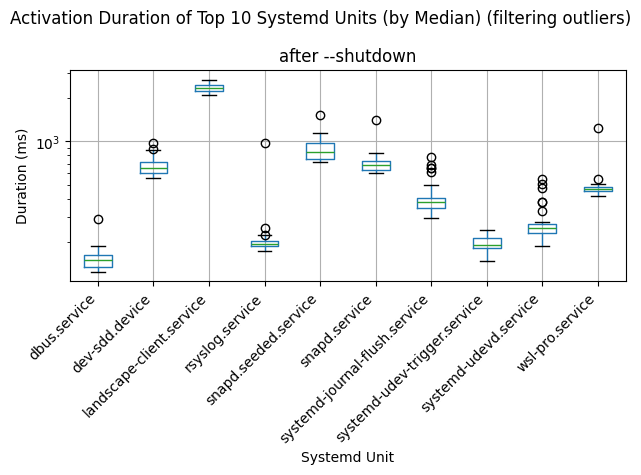

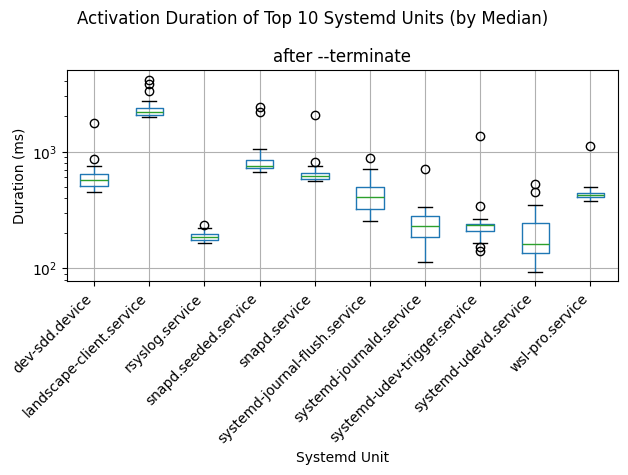

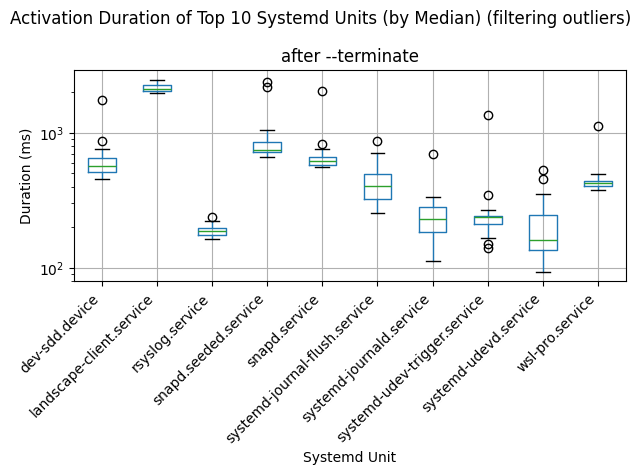

In [22]:
def plot_top_n(n: int, df: pd.DataFrame, annotation, with_outliers=True):
    title = f'Activation Duration of Top {n} Systemd Units (by Median)'
    # Calculate the median duration for each unit
    median_durations = df.groupby('Unit')['Duration'].median()

    # Sort the units by median duration in descending order
    top_5_units_median = median_durations.sort_values(ascending=False).head(n)

    df_top_n = df[df['Unit'].isin(top_5_units_median.index.to_list())]

    if not with_outliers:
        title += ' (filtering outliers)'
        df_top_n = filter_outliers(df_top_n, 'Duration')
    
    ax = df_top_n.boxplot(column='Duration', by='Unit')
    ax.set_yscale('log')
    plt.suptitle(title)
    plt.xlabel('Systemd Unit')
    plt.ylabel('Duration (ms)')
    plt.title(annotation)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


plot_top_n(10, shut2.blame, 'after --shutdown')
plot_top_n(10, shut2.blame, 'after --shutdown', False)

plot_top_n(10, term2.blame, 'after --terminate')
plot_top_n(10, term2.blame, 'after --terminate', False)